In [1]:
import pandas as pd
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import psycopg2 as pg
from urllib.parse import quote_plus
%matplotlib inline

In [3]:
# Database connections
username = input('Username for the rds ' )
password = input('Password to the rds ' )
server = input('Servername ' )
conrds = pyodbc.connect(driver = '{ODBC Driver 13 for SQL Server}',
                    server = str(server) +',1433',
                    database = 'water_crisis_proc',
                    user = str(username),
                    password = str(password))

conn =  'DRIVER={ODBC Driver 13 for SQL Server};gather-cpt-team-7.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com;DATABASE=water_crisis_proc;UID='+username+';PWD='+password+''
quoted = quote_plus(conn)
new_con = 'mssql+pyodbc:///?odbc_connect={}'.format(quoted)
engine = create_engine(new_con)

In [4]:
rain_data = pd.read_sql('select * from RecordedRainfall', conrds)

dam_levels = pd.read_sql('select * from DamLevels', conrds)

rain_stations = pd.read_sql('select * from RainStations', conrds)

supply_dams = pd.read_sql('select * from SupplyDams', conrds)

In [5]:
rain_df = pd.merge(rain_data, rain_stations, how = 'inner', on ='rain_station_id')
rain_df = rain_df[['date','precipitation', 'name', 'longitude', 'latitude']]

In [6]:
rain_df.head()

,date,precipitation,name,longitude,latitude
0,1974-10-01,0.0,ASSEGAAIBOS,19.06605,-33.94175
1,1974-11-01,0.0,ASSEGAAIBOS,19.06605,-33.94175
2,1974-12-01,0.0,ASSEGAAIBOS,19.06605,-33.94175
3,1975-01-01,48.4,ASSEGAAIBOS,19.06605,-33.94175
4,1975-02-01,17.1,ASSEGAAIBOS,19.06605,-33.94175


In [7]:
storage_df = pd.merge(dam_levels, supply_dams, how = 'inner', on = 'supply_dam_id')
storage_df = storage_df[['date',  'name','height', 'storage', 'total_dam_capacity', 'categories', 'longitude', 'latitude']]

In [8]:
storage_df.head()

,date,name,height,storage,total_dam_capacity,categories,longitude,latitude
0,2012-01-01,WEMMERSHOEK,48.2,44621.0,58634,Major Dam,19.091828,-33.826246
1,2012-01-02,WEMMERSHOEK,48.2,44571.0,58634,Major Dam,19.091828,-33.826246
2,2012-01-03,WEMMERSHOEK,48.2,44471.0,58634,Major Dam,19.091828,-33.826246
3,2012-01-04,WEMMERSHOEK,48.1,44372.0,58634,Major Dam,19.091828,-33.826246
4,2012-01-05,WEMMERSHOEK,48.1,44322.0,58634,Major Dam,19.091828,-33.826246


In [9]:
storage_df = storage_df[storage_df['storage'].notna()].copy()

In [10]:
def dates(df):
    df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

In [11]:
dates(storage_df)
dates(rain_df)

In [12]:
storage_df.head()

,date,name,height,storage,total_dam_capacity,categories,longitude,latitude,month,year
0,2012-01-01,WEMMERSHOEK,48.2,44621.0,58634,Major Dam,19.091828,-33.826246,1,2012
1,2012-01-02,WEMMERSHOEK,48.2,44571.0,58634,Major Dam,19.091828,-33.826246,1,2012
2,2012-01-03,WEMMERSHOEK,48.2,44471.0,58634,Major Dam,19.091828,-33.826246,1,2012
3,2012-01-04,WEMMERSHOEK,48.1,44372.0,58634,Major Dam,19.091828,-33.826246,1,2012
4,2012-01-05,WEMMERSHOEK,48.1,44322.0,58634,Major Dam,19.091828,-33.826246,1,2012


In [13]:
def merging(df_x, df_y, group, column_x, column_y, shift = 0):
    
    x = df_x.groupby(group)[[column_x]].mean().shift()
    y = df_y.groupby(group)[[column_y]].mean().diff()
    merge = pd.merge(x,y,how = 'inner', on = group)
    return merge

In [14]:
merged = merging(rain_df, storage_df, 'month', 'precipitation', 'storage',1)

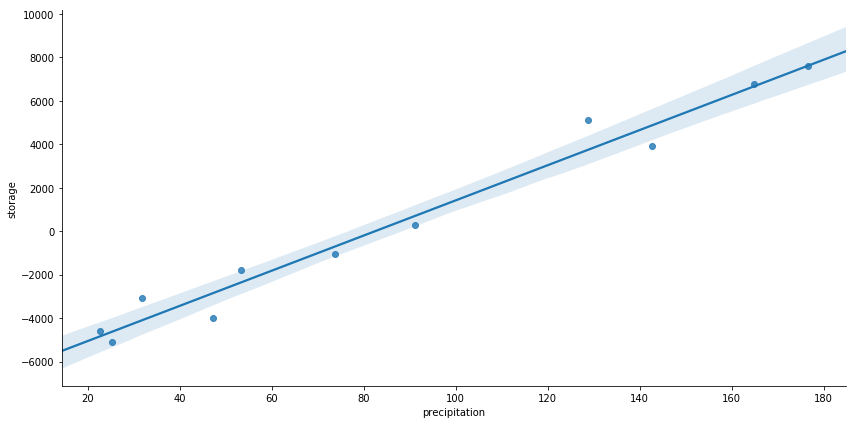

In [15]:
sns.lmplot(x = 'precipitation', y = 'storage', data = merged, height = 6, aspect = 2)
#plt.savefig('fig.png')

In [16]:
merged.head()

,precipitation,storage
month,,
1,NaN,NaN
2,25.229240,-5113.185530
3,22.651332,-4572.367466
4,31.671961,-3090.406593
5,73.819399,-1050.499823


In [17]:
def subplots_db(df, column_1,label_1, column_2, label_2,  title_):    
    fig, ax = plt.subplots(figsize = [24,8])
    plt.plot(df[column_1], label = label_1)
    plt.legend(loc=2)
    ax.tick_params('vals')

    plt.gca().set_title(title_)

    ax2 = ax.twinx()
    plt.plot(df[column_2], 'orange', label = label_2)
    plt.legend(loc=1)
    ax.tick_params('vals')
    #plt.savefig('water_storage_rain.png')

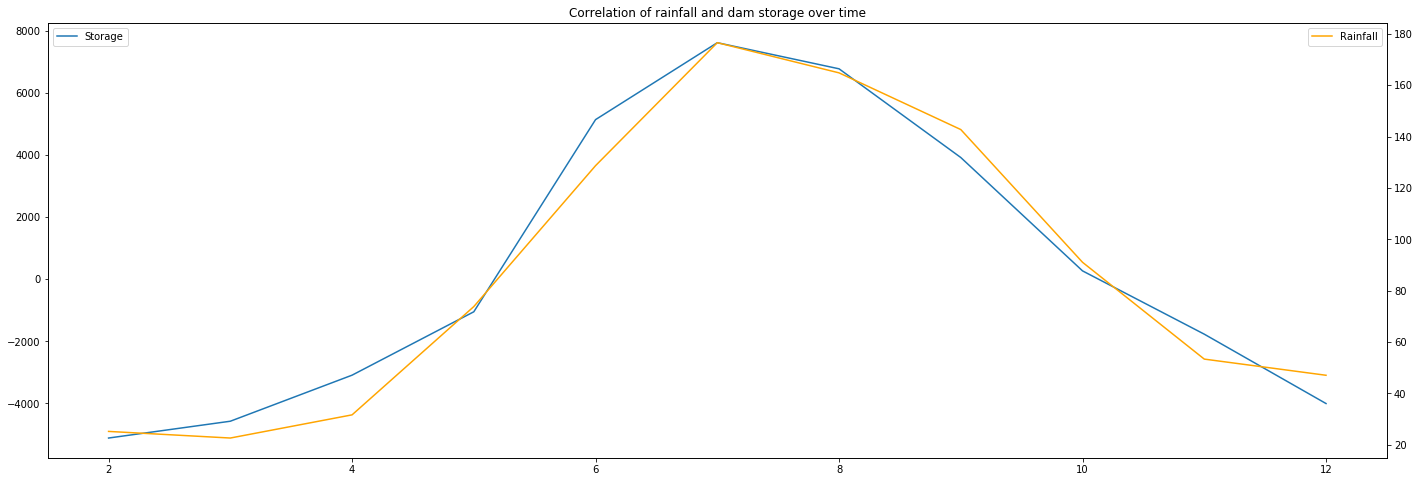

In [18]:
subplots_db(merged,'storage', 'Storage', 'precipitation', 'Rainfall', 'Correlation of rainfall and dam storage over time')

In [19]:
def station_distance_to_dam(dam_name):
       
    df_ = {}
    for i in rain_df['name']:    
        delta_x = storage_df[storage_df['name'] == dam_name]['longitude'].values[0] - rain_df[rain_df['name'] == i]['longitude'].values[0]
        delta_y = storage_df[storage_df['name'] == dam_name]['latitude'].values[0] - rain_df[rain_df['name'] == i]['latitude'].values[0]
        df_.update({i:round(np.sqrt(delta_x**2 + delta_y**2),3)})
    df = df_
    
    return df

In [24]:
corr = station_distance_to_dam("VICTORIA")